In [1]:
#NOW TRAINING SECTION 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
import os
import pandas as pd
import sys
from collections import Counter
from pathlib import Path
import numpy

In [13]:
#getting necessary  transforms with out dataset
tfms =get_transforms(do_flip = True,
                                 flip_vert=True, 
                                 max_lighting=0.1, 
                                 max_zoom=1.05,
                                 max_warp=0.,
                                 max_rotate=15,
                                 p_affine=0.75,
                                 p_lighting=0.75
                                )
#path equal to directory which contains the  images , and a labels csv file
path=r'/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/'

In [24]:
src = (ImageList.from_csv(path, 'file2.csv', folder='images', suffix='.jpg',header=None)
       .split_by_rand_pct(0.1)
       .label_from_df(cols=5))

#run these instead of above if you have preprocessed the data and made seperate images folder for each label
# path=r'/home/uzair/Desktop/organized_data_plants/'
# src=(ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
#         .split_by_rand_pct(0.2)             #How to split in train/valid? -> use the folders
#         .label_from_folder() )           #How to label? -> depending on the folder of the filenames
                       

In [25]:
#creating a databunch
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
data.batch_size=8

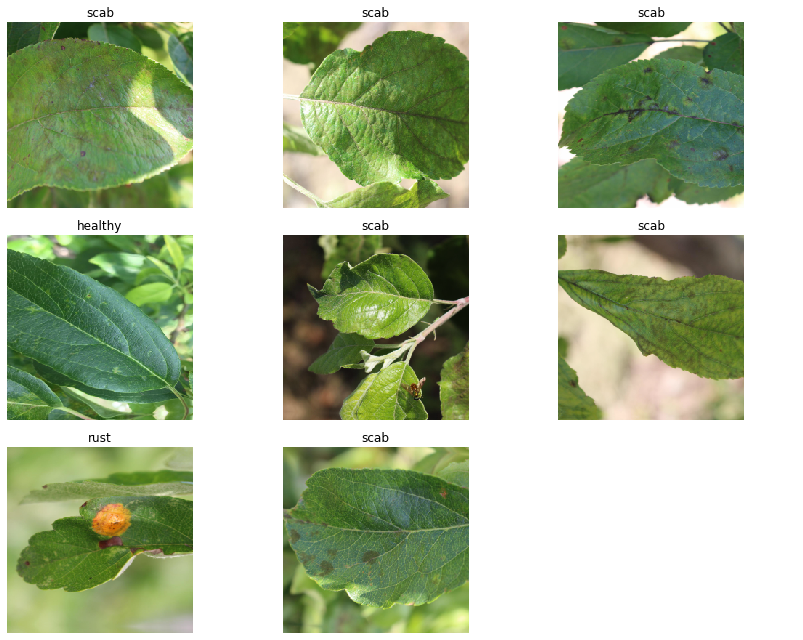

In [27]:
#displaying the data
data.show_batch(rows=3, figsize=(12,9))

In [28]:
#choosing the model , and metrics to display while training
learn = cnn_learner(data, models.densenet121, metrics=[accuracy,error_rate])

In [32]:
data

ImageDataBunch;

Train: LabelList (1639 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
scab,multiple_diseases,rust,healthy,multiple_diseases
Path: /home/uzair/Downloads/data/plant-pathology-2020-fgvc7;

Valid: LabelList (182 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
rust,rust,scab,rust,rust
Path: /home/uzair/Downloads/data/plant-pathology-2020-fgvc7;

Test: None

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.39E-05
Min loss divided by 10: 9.50E-04


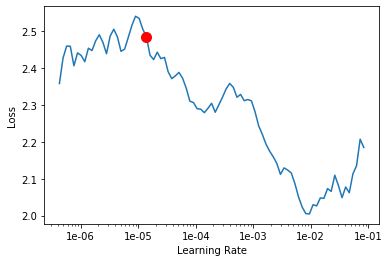

In [9]:
#auto-learning rate finder, works sometime ......but not always
learn.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learn.recorder.plot(suggestion=True)


In [9]:
mingradlr = learn.recorder.min_grad_lr

In [10]:
lr = mingradlr
#TRAINING FOR 13 EPOCHS
learn.fit_one_cycle(13 ,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.081788,0.550650,0.787618,0.212382,04:31
1,0.876835,0.319068,0.880878,0.119122,04:31
2,0.717781,0.258389,0.905172,0.094828,04:24
3,0.555631,0.194810,0.934953,0.065047,04:27
4,0.405603,0.159295,0.936520,0.063480,04:26
5,0.338873,0.105843,0.963950,0.036050,04:27
6,0.311734,0.075787,0.978056,0.021944,04:25
7,0.292329,0.063504,0.981975,0.018025,04:27
8,0.266800,0.067545,0.973354,0.026646,04:29
9,0.275803,0.047085,0.986677,0.013323,04:29


In [ ]:
#saving model
learn.save('densenet20_with_unfreezed')

In [ ]:
#loading again
learn.load('densenet20_with_unfreezed')

In [33]:
#unfreezing the whole model and training more epochs
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-03/20, 1e-03/50))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.123476,0.014437,0.994505,0.005495,01:18
1,0.074511,0.013345,0.994505,0.005495,01:17
2,0.118401,0.013607,0.994505,0.005495,01:16
3,0.055875,0.010256,1.000000,0.000000,01:17
4,0.117910,0.006170,1.000000,0.000000,01:17
5,0.094511,0.009105,1.000000,0.000000,01:20
6,0.068427,0.009719,0.994505,0.005495,01:19
7,0.058399,0.005904,1.000000,0.000000,01:19
8,0.125176,0.007624,1.000000,0.000000,01:19
9,0.066084,0.004815,1.000000,0.000000,01:19


In [14]:
#now prediction time
#open up the csv file which contains the directories names of test images
test_df=pd.read_csv('/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test.csv')

In [15]:
test = (ImageList.from_df(test_df,path,
                          folder='test_images',
                          suffix='.jpg',
                          cols='image_id'))
       

In [16]:
test

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /home/uzair/Downloads/data/plant-pathology-2020-fgvc7

In [17]:
test.items
#now we have file-name directory for each test image

array(['/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_0.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_1.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_2.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_3.jpg', ...,
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_1817.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_1818.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_1819.jpg',
       '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/Test_1820.jpg'], dtype='<U79')

In [42]:
#prediction ftn which takes a image ,passes it through the model , and saves the results in stack formation
#in the variable final_stacked_result
def get_all_predictions():
  
  final_stacked_result=None
  for batch in range(len(test)):
         my_image=open_image(test.items[batch])
         predictions = learn.predict(my_image)[2].reshape(1,-1)
#          predictions=my_network(batch.to(device))
#          test_prediction=predictions.data.cpu()
         if final_stacked_result is None:
            final_stacked_result=predictions
            
         else:
             final_stacked_result=torch.cat((final_stacked_result,predictions),dim=0)
  return final_stacked_result

#calling the function 
my_predictions=get_all_predictions()

In [43]:
my_predictions.shape

torch.Size([1821, 4])

In [44]:
#reading_test_csv
my_test_csv1=pd.read_csv('/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test.csv')
my_test_csv1

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
5,Test_5
6,Test_6
7,Test_7
8,Test_8
9,Test_9


In [45]:
#pasting the probabilities of each label in required format
my_test_csv1['healthy']=np.array(my_predictions[:,0])
my_test_csv1['multiple_diseases']=np.array(my_predictions[:,1])
my_test_csv1['rust']=np.array(my_predictions[:,2])
my_test_csv1['scab']=np.array(my_predictions[:,3])

In [46]:
my_test_csv1

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,6.471693e-05,0.004129,9.958060e-01,1.680908e-07
1,Test_1,8.153367e-08,0.000117,9.998823e-01,7.971885e-07
2,Test_2,3.565621e-08,0.000024,1.849970e-09,9.999760e-01
3,Test_3,9.933363e-01,0.000179,6.484461e-03,3.257479e-07
4,Test_4,3.311765e-06,0.002949,9.970475e-01,1.921771e-08
5,Test_5,9.962484e-01,0.001175,2.564446e-03,1.214439e-05
6,Test_6,9.999574e-01,0.000038,4.240039e-06,4.276982e-09
7,Test_7,2.787783e-07,0.001290,8.801235e-12,9.987096e-01
8,Test_8,1.959966e-03,0.918738,1.252576e-07,7.930139e-02
9,Test_9,1.038919e-04,0.004094,9.958022e-01,6.992158e-11


In [47]:
#saving to desktop
my_test_csv1.to_csv('densenet3.csv',index=False)

In [ ]:
#run these to clear out the cuda-gpu memory and ram as well
torch.cuda.empty_cache()
learn.destroy()